In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import torch
from loader import *
import matplotlib.pyplot as plt
import h5py
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.ticker import MaxNLocator
from utils import *
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

logging.disable(logging.CRITICAL)

# Figure 6: Heuristic vs. optimized PV for what the PV source term concerns

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

In [4]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = False
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


### Heuristic PV

In [5]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)

PV_Xu_train_source = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_train_source = PV_Xu_train_source.to_numpy().reshape(-1,1)

Output_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']

output_matrix = state_space_train[Output_species].to_numpy()

## Visualize PV source term

C:\Windows\Temp\ipykernel_11692\2703946420.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


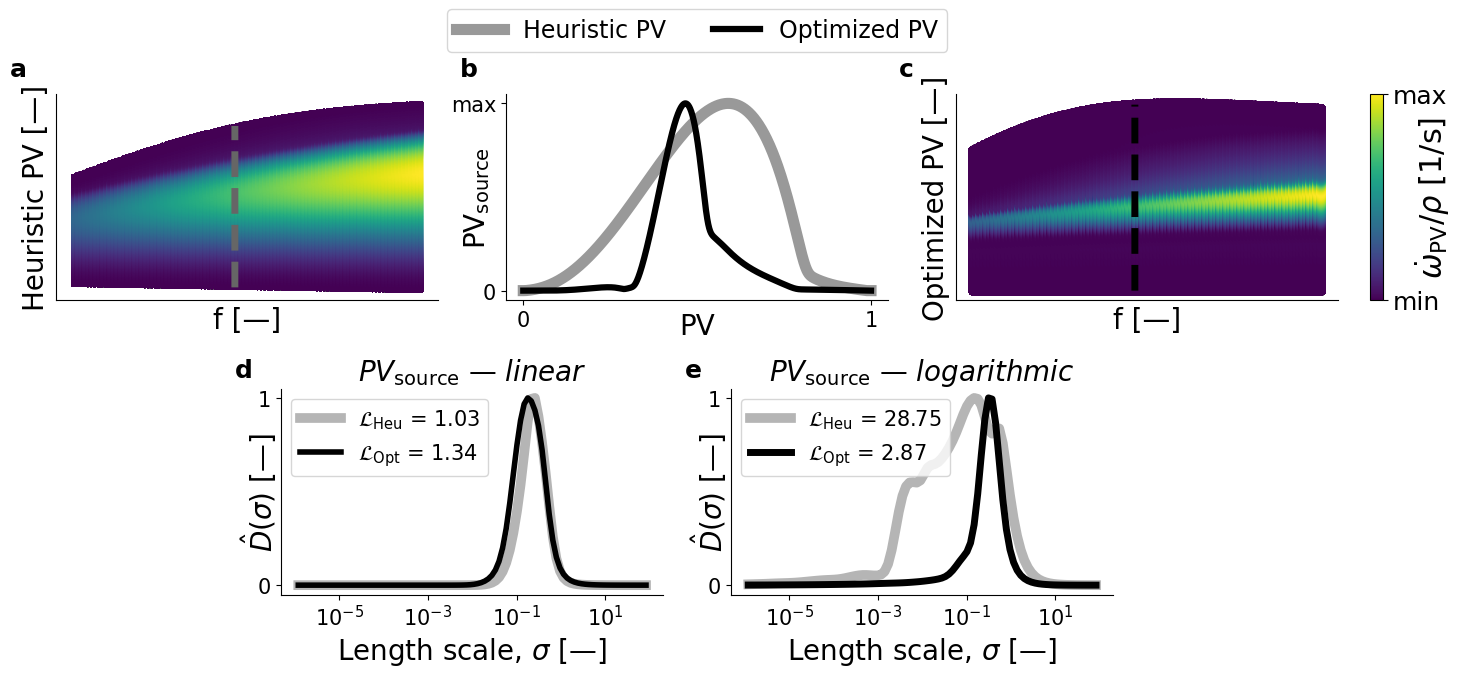

In [17]:
def add_panel_label(ax, label, x_offset=-0.12, y_offset=1.18, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )


save = True
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
name = "Figure 6 - PV source term - optimized vs heuristic PV - 2s - no spines - labels.png"

fig = plt.figure(figsize=(18, 6.5))  # slightly taller figure

# GridSpec: 3 rows, 12 columns for fine control
gs = gridspec.GridSpec(2, 13, height_ratios=[1, 1], hspace=0.43, wspace=1.5)

# -----------------------------
# Top row: 2 plots
# -----------------------------
ax00 = fig.add_subplot(gs[0, 0:4])   # top-left (Heuristic PV)
ax01 = fig.add_subplot(gs[0, 4:8])   # top-left (Heuristic PV)
ax02= fig.add_subplot(gs[0, 8:12])  # top-right (Optimized PV)
ax03 = fig.add_subplot(gs[0, 12])    # small colorbar axis (optional)

pos = ax03.get_position()
ax03.set_position([pos.x0-0.02, pos.y0, pos.width*0.3, pos.height])  # adjust colorbar

# -----------------------------
# Second row: 2 plots (Dhat)
# -----------------------------
ax10 = fig.add_subplot(gs[1, 2:6])   # bottom-left (Dhat linear)
ax11 = fig.add_subplot(gs[1, 6:10])  # bottom-right (Dhat logarithmic)

pos = ax03.get_position()
ax03.set_position([pos.x0, pos.y0, pos.width, pos.height])

#################################
# Top left - Heuristic PV
#################################
ax00.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)

# Test state space
idxTraj = 4
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]

ax00.plot(np.full(PV_heuristic_test.shape[0], mixture_fractions_test[idxTraj]),
              PV_heuristic_test, color=str(0.4), linestyle="--", linewidth=5)

ax00.set_xlabel("f [\u2014]", fontsize=20)
ax00.set_ylabel("Heuristic PV [\u2014]", fontsize=20)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

#################################
# Top right - Optimized PV
#################################


with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

ax02.plot(np.full(PV_optimized_test.shape[0], mixture_fractions_test[idxTraj]),
                 PV_optimized_test, color="k", linestyle = "--", linewidth=5)

sc = ax02.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis')

ax02.set_xlabel("f [\u2014]", fontsize=20)
ax02.set_ylabel("Optimized PV [\u2014]", fontsize=20)
ax02.set_xticks([])
ax02.set_yticks([])
ax02.spines['top'].set_visible(False)
ax02.spines['right'].set_visible(False)

# Add colorbar in dedicated axis cax:
cbar = fig.colorbar(sc, cax=ax03, orientation='vertical')
cbar.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=22, labelpad=-25)
vmin = PV_optimized_source_train.min()
vmax = PV_optimized_source_train.max()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=18)


#################################
# Bottom left - logPVsource trajectory
#################################
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())

    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax01.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx]/PV_Xu_source_test[:first_negative_idx].max(),
              linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax01.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx]/PV_optimized_source_test[:first_negative_idx].max(),
              linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

ax01.set_xlabel("PV", fontsize=20, labelpad=-13)
ax01.set_ylabel("PV$_{\mathrm{source}}$", fontsize=20, labelpad = -30)
ax01.set_xticks([0, 1])
ax01.tick_params(axis='x', labelsize=15)
ax01.tick_params(axis='y', labelsize=15)
#ax01.set_ylim([1e-7, 2e6])
#ax01.set_yscale("log")
#ax01.set_yticks([1e-7, 1e6])
ax01.set_yticks([0, 1])
ax01.set_yticklabels(["0", "max"])
ax01.legend(fontsize=17, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.47)) #, bbox_to_anchor=(0.5, 1.24) #, loc='upper center', bbox_to_anchor=(0.5, 1.15)

#################################
# Bottom right - Dhat curve
#################################

path_variance = "data-files/costs/"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

greys = cm.get_cmap('Greys')

name_optimized_0D = "variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition.npy" #"variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)


costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax10.plot(bandwidth_values_heuristic_0D,
              derivative_heuristic_0D['PV1'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D[-1]:.2f}',
              linewidth=7, linestyle="-")

ax10.plot(bandwidth_values_optimized_0D,
              derivative_optimized_0D[19],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D[-1]:.2f}',
              linewidth=4, linestyle="-")


ax10.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=20)
ax10.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=20, labelpad = -15)
ax10.set_xscale("log")
ax10.set_yticks([0, 1])
ax10.tick_params(axis='x', labelsize=15)
ax10.tick_params(axis='y', labelsize=15)
ax10.set_title(r"$\mathit{PV_{\mathrm{source}}}$" + " \u2014 " + r"$\mathit{linear}$", fontsize=20)
ax10.legend(fontsize=15)



name_optimized_0D_logPVsource = "variance_Tr0D-2s_s2-bw_-6_2_100-dataset_autoignition_logPVsource.npy"  #"variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition_logPVsource.npy"
name_heuristic_0D_logPVsource = "variance_Xu-bw_-6_2_100-dataset_autoignition_logPVsource.npy"

variance_optimized_0D_logPVsource = np.load(f"{path_variance}{name_optimized_0D_logPVsource}", allow_pickle=True).item()
variance_heuristic_0D_logPVsource = np.load(f"{path_variance}{name_heuristic_0D_logPVsource}", allow_pickle=True).item()

(derivative_optimized_0D_logPVsource, bandwidth_values_optimized_0D_logPVsource, max_derivative_optimized_0D_logPVsource) = normalized_variance_derivative(variance_optimized_0D_logPVsource)
(derivative_heuristic_0D_logPVsource, bandwidth_values_heuristic_0D_logPVsource, max_derivative_heuristic_0D_logPVsource) = normalized_variance_derivative(variance_heuristic_0D_logPVsource)


costsOptimized_0D_logPVsource = cost_function_normalized_variance_derivative(variance_optimized_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D_logPVsource = cost_function_normalized_variance_derivative(variance_heuristic_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax11.plot(bandwidth_values_heuristic_0D_logPVsource,
              derivative_heuristic_0D_logPVsource['logPVsource'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D_logPVsource[0]:.2f}',
              linewidth=7, linestyle="-")

ax11.plot(bandwidth_values_optimized_0D_logPVsource,
              derivative_optimized_0D_logPVsource['logPVsource'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D_logPVsource[0]:.2f}',
              linewidth=5)


ax11.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=20)
ax11.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=20, labelpad = -15)
ax11.set_xscale("log")
ax11.set_yticks([0, 1])
ax11.tick_params(axis='x', labelsize=15)
ax11.tick_params(axis='y', labelsize=15)
ax11.set_title(r"$\mathit{PV_{\mathrm{source}}}$" + " \u2014 " + r"$\mathit{logarithmic}$", fontsize=20)
ax11.legend(fontsize=15)

for ax in [ax00, ax01, ax02, ax10, ax11]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

add_panel_label(ax00, "a")
add_panel_label(ax01, "b")
add_panel_label(ax02, "c", x_offset=-0.15)
add_panel_label(ax10, "d", y_offset= 1.15)
add_panel_label(ax11, "e", y_offset= 1.15)


if(save):
    plt.savefig(pathSave + name, dpi=1000, bbox_inches='tight')

plt.show()